In [7]:
!pip install "tensorflow>=1.7.0"
!pip install tensorflow-addons
!pip install tensorflow-hub

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, utils
import tensorflow_addons as tfa

In [9]:
import numpy as np
import tensorflow as tf
print(f"tensorflow version: {tf.__version__}")
from tensorflow.keras import layers
from tensorflow.keras.layers import Layer, Conv2D, MaxPooling2D

import matplotlib.pyplot as plt

tensorflow version: 2.15.0


In [10]:
import json
import math
import os
import statistics
from keras import layers
from keras import backend as K
from keras.models import Sequential
from keras.preprocessing import image
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.layers import Input, Dense, DepthwiseConv2D,AveragePooling2D, Concatenate, Dropout, Permute,Reshape,Lambda,Activation, Add,Multiply, MaxPooling2D, Conv2D, Flatten, BatchNormalization, GlobalAveragePooling2D,LayerNormalization

import tensorflow as tf
from tensorflow.keras.applications import VGG16,ConvNeXtTiny,ResNet50, MobileNet, Xception, EfficientNetB0 , DenseNet169, DenseNet201, DenseNet121, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from tensorflow.keras.optimizers.legacy import Adam, SGD
from tensorflow.keras.metrics import Precision, Recall, AUC

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
from keras.models import Model
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import gc
import itertools
from tqdm import tqdm
from PIL import Image
from functools import partial
from collections import Counter
from statistics import mean

from keras.models import load_model
#from keras.models import Sequential
from matplotlib import pyplot as plt
import h5py
import cv2
import glob

%matplotlib inline


In [11]:
import tensorflow as tf
tf.version.VERSION, tf.config.list_physical_devices()

('2.15.0',
 [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')])

In [12]:
A = '/kaggle/input/iw-dataset/IW/400/A'
F = '/kaggle/input/iw-dataset/IW/400/F'
PT ='/kaggle/input/iw-dataset/IW/400/PT'
TA ='/kaggle/input/iw-dataset/IW/400/TA'
DC ='/kaggle/input/iw-dataset/IW/400/DC'
LC ='/kaggle/input/iw-dataset/IW/400/LC'
MC ='/kaggle/input/iw-dataset/IW/400/MC'
PC ='/kaggle/input/iw-dataset/IW/400/PC'

In [13]:
dirlist=[A, F, PT, TA, DC, LC, MC, PC]
classes=['A','F', 'PT', 'TA', 'DC', 'LC', 'MC', 'PC']
filepaths=[]
labels=[]
for i,j in zip(dirlist, classes):
    filelist=os.listdir(i)
    for f in filelist:
        filepath=os.path.join (i,f)
        filepaths.append(filepath)
        labels.append(j)
print ('filepaths: ', len(filepaths), '   labels: ', len(labels))

filepaths:  1820    labels:  1820


In [14]:
Files=pd.Series(filepaths, name='filepaths')
Label=pd.Series(labels, name='labels')
df=pd.concat([Files,Label], axis=1)
df=pd.DataFrame(np.array(df).reshape(len(filepaths),2), columns = ['filepaths', 'labels'])
df.head()

,filepaths,labels
0,/kaggle/input/iw-dataset/IW/400/A/SOB_B_A-14-2...,A
1,/kaggle/input/iw-dataset/IW/400/A/SOB_B_A-14-2...,A
2,/kaggle/input/iw-dataset/IW/400/A/SOB_B_A-14-2...,A
3,/kaggle/input/iw-dataset/IW/400/A/SOB_B_A-14-2...,A
4,/kaggle/input/iw-dataset/IW/400/A/SOB_B_A-14-2...,A


In [15]:
print(df['labels'].value_counts())

labels
DC    788
F     237
MC    169
PC    138
LC    137
TA    130
PT    115
A     106
Name: count, dtype: int64


In [16]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, train_size=0.70)
#train_new, valid = train_test_split(train, train_size=0.90, random_state=0)

print(f"train set shape: {train.shape}")
print(f"test set shape: {test.shape}")
print(f"validation set shape: {test.shape}")

train set shape: (1274, 2)
test set shape: (546, 2)
validation set shape: (546, 2)


In [17]:
# train = '/content/drive/MyDrive/fold5/40/train'
# test = '/content/drive/MyDrive/fold5/40/test'

In [18]:
train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2,
                                   shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, vertical_flip =True)
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

In [19]:
# Define tand get the number os devices. 
strategy = tf.distribute.MirroredStrategy()
print('DEVICES AVAILABLE: {}'.format(strategy.num_replicas_in_sync))

train_gen = train_datagen.flow_from_dataframe(dataframe=train,
                                              x_col = 'filepaths', y_col ='labels',
                                              target_size = (224,224), batch_size = 4 * strategy.num_replicas_in_sync,
                                              class_mode = 'categorical', shuffle = True)

val_gen = test_datagen.flow_from_dataframe(test,
                                            target_size = (224,224),   x_col = 'filepaths', y_col ='labels',
                                             class_mode = 'categorical',
                                            batch_size = 4 * strategy.num_replicas_in_sync, shuffle = False)


test_gen = test_datagen.flow_from_dataframe(test,
                                            target_size = (224,224),   x_col = 'filepaths', y_col ='labels',
                                             class_mode = 'categorical',
                                            batch_size = 4, shuffle = False)

DEVICES AVAILABLE: 1
Found 1274 validated image filenames belonging to 8 classes.
Found 546 validated image filenames belonging to 8 classes.
Found 546 validated image filenames belonging to 8 classes.


In [20]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

def plotmodel(history,name):

    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(1)
    plt.plot(epochs,smooth_curve(acc))
    plt.plot(epochs,smooth_curve(val_acc))
    plt.ylabel('acc')
    plt.xlabel('epoch')
    plt.legend(['train_acc', 'val_acc'], loc='upper left')
    #plt.savefig('acc_'+name+'_'+mag+'_'+fold+'.png')

    plt.figure(2)
    plt.plot(epochs,smooth_curve(loss))
    plt.plot(epochs,smooth_curve(val_loss))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'val_loss'], loc='upper right')
   # plt.savefig('loss_'+name+'_'+mag+'_'+fold+'.png')

def label_smooth(y_true, y_pred):
    y_true=((1-0.1)*y_true+0.05)
    return K.categorical_crossentropy(y_true, y_pred)


In [21]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 3.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="green" if cm[i, j] > thresh else "red", fontdict={'fontsize':'x-large'})

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [22]:
def DefConv_full(input, filters, kernel_size, strides=1):
    """
    Using DefConv_reduced to implement full DC layer.
    """
    offsets = layers.Conv2D(filters=2 * kernel_size ** 2,
                            kernel_size=kernel_size,
                            strides=strides,
                            padding='same',
                            kernel_initializer='random_normal'
                            )(input)
    X = DefConvLayer_red(filters=filters,
                         kernel_size=kernel_size,
                         strides=strides
                         )(input, offsets)
    return X



class DefConvLayer_red(Layer):

    def __init__(self, filters,strides, kernel_size=3, **kwargs):
        assert type(kernel_size) == int, "expect kernel_size to be of type 'int'"
        assert type(strides) == int, "expect strides to be of type int"
        self.N = kernel_size ** 2
        self.filters = filters
        self.strides = strides

        super(DefConvLayer_red, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], self.N, self.filters),
                                 # Wdc is of shape [n_C=input_channels, lxl=N, filters=output_channels]
                                 initializer='RandomNormal',
                                 dtype='float32',
                                 trainable=True)

    def call(self, input, offsets):
        # input of shape: (m=batch_size, n_H, n_W, n_C)
        # offsets of shape: (m, n_H, n_W, 2*N)
        # m, n_H, n_W, n_C = input.shape
        # offsets = super(DefConvLayer, self).call(input) # Conv2D to learn offsets (m, n_H, n_W, 2*N)

        input_offsets = self.BLIN(input, offsets)  # (m, n_H, n_W, n_C, N)
        # BLIN returns N interpolated values of input at the offsets, for each spatial pixel
        # replicate the offset input to each of the output channels
        input_offsets = tf.expand_dims(input_offsets, axis=-1)
        input_offsets = tf.tile(input_offsets, [1, 1, 1, 1, 1, self.filters])  # (m, n_H, n_W, n_C, N, filters)

        new_shape = (1, 1, 1,) + self.W.shape
        W = tf.reshape(self.W, shape=new_shape)  # (1, 1, 1, n_C, N, filters) to be broadcastable to input_offsets

        output = tf.multiply(input_offsets, W)  # (m, n_H, n_W, n_C, N, filters)
        output = tf.math.reduce_sum(output, axis=-2)  # (m, n_H, n_W, n_C, filters) reduce along each channel kernel
        output = tf.math.reduce_sum(output, axis=-2)  # (m, n_H, n_W, filters) reduce along input channels
        return output

    @tf.function
    def BLIN(self, input, offsets_in):  # Bi-Linear Interpolation of input feature map values at offset locations
        """
        'input' shape: (m, n_Hi, n_Wi, n_C)
        'offsets_in' shape: (m, n_Ho, n_Wo, 2*N)
        'offsets_in' is the output of the Conv2D layer step aimed at learning the offsets,
                     possibly smaller spatial size than input's, if strides>1
        """
        offsets = offsets_in
        m    = tf.shape(input)[0]
        n_Hi = tf.shape(input)[1]
        n_Wi = tf.shape(input)[2]
        n_C  = tf.shape(input)[3]

        n_Ho = tf.shape(offsets)[1] # also the output spatial shape
        n_Wo = tf.shape(offsets)[2]
        N    = tf.shape(offsets)[3] // 2

        # expand the input into (m, n_Hi, n_Wi, n_C, N). this will also be the output shape of this function
        input_offsets = tf.expand_dims(input, axis=-1) # (m, n_Hi, n_Wi, n_C, N, 1)
        # replicate N times, to be compatible with the kernel operation later
        input_offsets = tf.tile(input_offsets, [1, 1, 1, 1, N])  # (m, n_Hi, n_Wi, n_C, N)

        # the offset metrices will be replicated n_C times: same (spatial) offsets for each of the input *channels*.
        offsets = tf.reshape(offsets, (m, n_Ho, n_Wo, 1, N, 2))  # (m, n_Ho, n_Wo, 1, N, 2) add a "channel" axis
        offsets = tf.tile(offsets, [1, 1, 1, n_C, 1, 1])  # (m, n_Ho, n_Wo, n_C, N, 2) replicate for each of the input channels

        # construct a full index grid to be applied onto "input_offsets" of size (m, n_H, n_W, n_C, N)
        (grid_m, grid_i, grid_j, grid_c, grid_N) = tf.meshgrid(tf.range(m), tf.range(n_Hi),
                                                               tf.range(n_Wi), tf.range(n_C), tf.range(N),
                                                               indexing='ij')  # (m, n_Hi, n_Wi, n_C, N) a list of 5 metrices with index-like values

        # adjust indices to 'strides' down-sample, and
        # unroll indices to fit into tf.gather_nd later. (unroll offsets also)
        ur_grid_m = tf.reshape(grid_m[:, ::self.strides, ::self.strides, :, :], [-1])  # (m*n_Ho*n_Wo*n_C*N, 1); integers
        ur_grid_i = tf.reshape(grid_i[:, ::self.strides, ::self.strides, :, :], [-1])
        ur_grid_j = tf.reshape(grid_j[:, ::self.strides, ::self.strides, :, :], [-1])
        ur_grid_c = tf.reshape(grid_c[:, ::self.strides, ::self.strides, :, :], [-1])
        ur_grid_N = tf.reshape(grid_N[:, ::self.strides, ::self.strides, :, :], [-1])
        ur_offsets = tf.reshape(offsets, (-1, 2))  # (m*n_Ho*n_Wo*n_C*N, 2) both i, j

        # spatial indices will be adjusted using 'offsets'
        coords_i = tf.cast(ur_grid_i, dtype='float32') + ur_offsets[..., 0]
        coords_j = tf.cast(ur_grid_j, dtype='float32') + ur_offsets[..., 1]

        # Need to think further on how to handle edges,
        # perhaps assume outside of index values can be zeros instead of hard-clipping.
        coords_i = tf.clip_by_value(coords_i, 0, tf.cast(n_Hi, dtype='float32')-1)
        coords_j = tf.clip_by_value(coords_j, 0, tf.cast(n_Wi, dtype='float32')-1)
        coords_2d = tf.stack([coords_i, coords_j], axis=-1)  # (m*n_Ho*n_Wo*n_C*N, 2); float32

        # generate top and bottom, left and right, nearest "real" indices
        # assuming coords represents (p,q) values where i<=p<=i+1, and j<=q<=j+1:
        # shape: (m*n_Ho*n_Wo*n_C*N, 2)
        # note the coordinates themselves (values in coords) are [i,j] within [0:n_Hi-1, 0:n_Wi] range
        coords_lt = tf.cast(tf.math.floor(coords_2d), dtype='int32')  # nearest (i,j)
        coords_rb = tf.cast(tf.math.ceil(coords_2d), dtype='int32')  # nearest (i+1, j+1)

        coords_lb = tf.stack((coords_rb[..., 0], coords_lt[..., 1]), axis=-1)  # nearest (i+1, j)
        coords_rt = tf.stack((coords_lt[..., 0], coords_rb[..., 1]), axis=-1)  # nearest (i, j+1)

        # use the replicated input tensor "input_offsets" which holds the input values, to get these values at the specific locations:
        # these type of Tensors doesn't allow for conversion into numpy-like arrays. to use tf.gather_nd, need to unroll indices
        # unroll all grid tensors to be used with tf.gather_nd()

        indices_lt = tf.stack([ur_grid_m, coords_lt[..., 0], coords_lt[..., 1], ur_grid_c, ur_grid_N], axis=-1)
        indices_rb = tf.stack([ur_grid_m, coords_rb[..., 0], coords_rb[..., 1], ur_grid_c, ur_grid_N], axis=-1)
        indices_lb = tf.stack([ur_grid_m, coords_lb[..., 0], coords_lb[..., 1], ur_grid_c, ur_grid_N], axis=-1)
        indices_rt = tf.stack([ur_grid_m, coords_rt[..., 0], coords_rt[..., 1], ur_grid_c, ur_grid_N], axis=-1)

        vals_lt = tf.gather_nd(input_offsets, indices_lt)
        vals_rb = tf.gather_nd(input_offsets, indices_rb)
        vals_lb = tf.gather_nd(input_offsets, indices_lb)
        vals_rt = tf.gather_nd(input_offsets, indices_rt)

        # calculate the offset from the left-top (i,j) position
        ur_coords_offset_lt = coords_2d - tf.cast(coords_lt, dtype='float32')  # (m*n_Ho*n_Wo*n_C*N, 2)

        # first linear interpolation (m*n_H*n_W*n_C*N)
        vals_t = vals_lt + (vals_rt - vals_lt) * ur_coords_offset_lt[..., 1]  # along the j axis (n_Wi), top
        vals_b = vals_lb + (vals_rb - vals_lb) * ur_coords_offset_lt[..., 1]  # along the j axis (n_Wi), bottom

        # second linear interpolation
        input_offsets = vals_t + (vals_b - vals_t) * ur_coords_offset_lt[..., 0]  # along the i axis (n_Hi)

        # reshape back to output shape
        input_offsets = tf.reshape(input_offsets, (m, n_Ho, n_Wo, n_C, N))

        return input_offsets

In [23]:
def train_model(model,train_gen,val_gen,test_gen,mag,image_size,save_name,lr1,lr2,Epochs1,Epochs2):

    lr_decay=ReduceLROnPlateau(monitor='loss', factor=0.8, patience=3, verbose=1)
    from keras.callbacks import ModelCheckpoint
    save_model = ModelCheckpoint('/kaggle/working/400_epoch+{epoch:02d}.h5', monitor='val_acc', period=1, save_best_only=True)


    for layer in new_base_model.layers:
        layer.trainable = False

    model.compile(optimizer=Adam(lr=1e-5,decay=1e-6),loss=loss_fun,metrics=['acc'])
    model.fit_generator(train_gen,
                        #steps_per_epoch=train_num/batch_size,
                        validation_data=val_gen,
                        #validation_steps=test_num/batch_size,
                        epochs=Epochs1,
                        workers=8,
                        callbacks=[lr_decay,save_model])

    for layer in new_base_model.layers:
        layer.trainable = True

    model.compile(optimizer=Adam(lr=lr2,decay=0.00001),loss=loss_fun,metrics=['acc'])
    history = model.fit_generator(train_gen,
                        #steps_per_epoch=train_num/batch_size,
                        validation_data=val_gen,
                        #validation_steps=test_num/batch_size,
                        epochs=Epochs2,
                        workers=8,
                        callbacks=[lr_decay,save_model])

    results =model.evaluate(test_gen)
    print('Test loss and accuracy: ',results)
    predictions = model.predict(test_gen)
    rounded_pred = np.argmax(predictions, axis=-1)
    cm = confusion_matrix(y_true=test_gen.classes, y_pred=rounded_pred)
    cm_plot_labels = ['A','F', 'PT', 'TA', 'DC', 'LC', 'MC', 'PC']
    plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')
    print(classification_report(y_true=test_gen.classes, y_pred=rounded_pred, target_names=cm_plot_labels))


    return history

In [24]:
!pip install -U git+https://github.com/leondgarse/keras_cv_attention_models

  Cloning https://github.com/leondgarse/keras_cv_attention_models to /tmp/pip-req-build-8s3r4x9h
  Running command git clone --filter=blob:none --quiet https://github.com/leondgarse/keras_cv_attention_models /tmp/pip-req-build-8s3r4x9h
  Resolved https://github.com/leondgarse/keras_cv_attention_models to commit 4e9156520cfd700bb78d491983e39160647f6b19
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 1.9 MB/s eta 0:00:00
  Created wheel for keras-cv-attention-models: filename=keras_cv_attention_models-1.4.2-py3-none-any.whl size=933481 sha256=832dd47d080451a130a9e443a0cb443ba883c6fa16cc4604514d5720838f57c6
  Stored in directory: /tmp/pip-ephem-wheel-cache-48agrb2f/wheels/16/98/1e/847241ad48bd552bd921ea08001f22a1ecab471036f6b09bb4
Successfully built keras-cv-attention-models


In [25]:
from keras_cv_attention_models import maxvit
mm = maxvit.MaxViT_Tiny(input_shape=(224, 224, 3), pretrained="imagenet")
# mm.summary()

126113280/126113280 [==============================] - 1s 0us/step
>>>> Load pretrained from: /root/.keras/models/maxvit_tiny_224_imagenet.h5


In [26]:
import keras.backend as K
def SSA(inputs,fltr):
    shape=K.int_shape(inputs)
    li=q=k=v=Conv2D(fltr,1,padding='same',activation='relu')(inputs)
    print("Shape of Input of SSA", inputs)
    Qshape=K.int_shape(q)
    Kshape= K.int_shape(k)
    Vshape= K.int_shape(v)
    a=Qshape[1]*Qshape[2]
    q=Reshape((a,Qshape[3]))(q)
    k=Reshape((a,Kshape[3]))(k)
    k=Permute((2,1))(k)
    qk=tf.matmul(q,k)
    qk=Activation('softmax')(qk)
    v=Reshape((a,Vshape[3]))(v)
    qkv=tf.matmul(qk,v)
    print(qkv.shape)
    qkv=Reshape((Vshape[1],Vshape[2],Vshape[3]))(qkv)
    qkv = Conv2D(shape[3], 1, strides=1, padding='same', activation='relu')(qkv)
    print("Shape of Output of SSA", qkv)
    return qkv

In [27]:
import keras.backend as K

def CDSA(input, fltr, nh):
    attn = []
    print("Shape of CDSA Input", input.shape)
    feature_split = tf.split(input, num_or_size_splits=num_splits, axis=3)
    print(feature_split[0].shape)
    shape = K.int_shape(feature_split[0])
    x = SSA(feature_split[0], fltr)
    attn.append(x)
    for i in range(1, nh):
        y = SSA(feature_split[i], fltr)
        attn.append(y)
    mh_lka_attn = Add()(attn)
    mh_lka_attn = Conv2D(fltr, 1, strides=1, padding='same', activation='relu')(mh_lka_attn)
    print("Shape of CDSA Output", mh_lka_attn.shape)
    return mh_lka_attn


In [28]:
def CAL(input,fltr,nh):
    print("Shape of CAL Input", input.shape)
    x = DefConv_full(input, fltr, kernel_size=3)
    rs1 = x = Add()([x,input])
    x = LayerNormalization(epsilon=1e-6)(x)
    x = CDSA(x,fltr,nh)
    rs2 = x = Add()([rs1,x])
    x = LayerNormalization(epsilon=1e-6)(x)
    x = Conv2D(fltr, 1, padding='same', activation='relu')(x)
    x = Add()([rs2,x])
    print("Shape of CAL Output", x.shape)
    return x


In [29]:
loss_fun= 'categorical_crossentropy'
gpu_num=2
k=5
lr1=0.005
lr2=0.0001
image_size=224
classes=8
ratio=8
fltr=256
nh=4 # number of splits
mag='40'

In [30]:
from tensorflow.keras.layers import BatchNormalization, Dropout

input_image = Input(shape=(224, 224, 3))
mn_input = input_image

# Load the model
base_model = maxvit.MaxViT_Tiny(input_shape=(224, 224, 3), pretrained="imagenet")
new_base_model = Model(inputs=base_model.input, outputs=base_model.get_layer('stack_3_block_5/grid_ffn_output').output)
mn_output = new_base_model(mn_input)
print(mn_output.shape)

mn_output = Conv2D(fltr, 1, padding='same', activation='relu')(mn_output)
print(mn_output.shape)
mn_output = BatchNormalization()(mn_output)  # Add Batch Normalization
mn_output = Dropout(0.5)(mn_output)
num_splits = 4
CAL_out = CAL(mn_output,fltr,nh)
print(CAL_out.shape)
CAL_out = GlobalAveragePooling2D()(CAL_out)
out=Dense(classes,activation='softmax')(CAL_out)
if gpu_num<1:
    model=Model(inputs=input_image, outputs=out)
    #model.summary()
    parallel_model = multi_gpu_model(model, gpus=gpu_num)
    parallel_model.summary()
else:
    parallel_model=Model(inputs=input_image, outputs=out)
    parallel_model.summary()

>>>> Load pretrained from: /root/.keras/models/maxvit_tiny_224_imagenet.h5
(None, 14, 14, 256)
(None, 14, 14, 256)
Shape of CAL Input (None, 14, 14, 256)
Shape of CDSA Input (None, 14, 14, 256)
(None, 14, 14, 64)
Shape of Input of SSA KerasTensor(type_spec=TensorSpec(shape=(None, 14, 14, 64), dtype=tf.float32, name=None), name='tf.split_44/split:0', description="created by layer 'tf.split_44'")
(None, 196, 256)
Shape of Output of SSA KerasTensor(type_spec=TensorSpec(shape=(None, 14, 14, 64), dtype=tf.float32, name=None), name='conv2d_3/Relu:0', description="created by layer 'conv2d_3'")
Shape of Input of SSA KerasTensor(type_spec=TensorSpec(shape=(None, 14, 14, 64), dtype=tf.float32, name=None), name='tf.split_44/split:1', description="created by layer 'tf.split_44'")
(None, 196, 256)
Shape of Output of SSA KerasTensor(type_spec=TensorSpec(shape=(None, 14, 14, 64), dtype=tf.float32, name=None), name='conv2d_5/Relu:0', description="created by layer 'conv2d_5'")
Shape of Input of SSA Ker

/opt/conda/lib/python3.10/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/tmp/ipykernel_34/2124433108.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_gen,


Epoch 1/4


2024-04-27 20:52:06.607453: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


319/319 [==============================] - ETA: 0s - loss: 1.9238 - acc: 0.3564

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


319/319 [==============================] - 174s 453ms/step - loss: 1.9238 - acc: 0.3564 - val_loss: 1.8927 - val_acc: 0.3974 - lr: 1.0000e-05
Epoch 2/4
319/319 [==============================] - 135s 422ms/step - loss: 1.7958 - acc: 0.4137 - val_loss: 1.7217 - val_acc: 0.4322 - lr: 1.0000e-05
Epoch 3/4
319/319 [==============================] - 140s 438ms/step - loss: 1.6803 - acc: 0.4435 - val_loss: 1.6310 - val_acc: 0.4615 - lr: 1.0000e-05
Epoch 4/4
319/319 [==============================] - 134s 419ms/step - loss: 1.6373 - acc: 0.4458 - val_loss: 1.5528 - val_acc: 0.4799 - lr: 1.0000e-05
Epoch 1/100


/tmp/ipykernel_34/2124433108.py:24: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,
2024-04-27 21:01:55.265176: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


319/319 [==============================] - 195s 508ms/step - loss: 1.4937 - acc: 0.4961 - val_loss: 1.1838 - val_acc: 0.6062 - lr: 1.0000e-04
Epoch 2/100
319/319 [==============================] - 155s 485ms/step - loss: 1.3213 - acc: 0.5392 - val_loss: 1.5327 - val_acc: 0.4634 - lr: 1.0000e-04
Epoch 3/100
319/319 [==============================] - 163s 509ms/step - loss: 1.0992 - acc: 0.5918 - val_loss: 0.9994 - val_acc: 0.6520 - lr: 1.0000e-04
Epoch 4/100
319/319 [==============================] - 155s 484ms/step - loss: 1.0253 - acc: 0.6358 - val_loss: 0.9614 - val_acc: 0.6502 - lr: 1.0000e-04
Epoch 5/100
319/319 [==============================] - 155s 484ms/step - loss: 0.9942 - acc: 0.6374 - val_loss: 2.6060 - val_acc: 0.3370 - lr: 1.0000e-04
Epoch 6/100
319/319 [==============================] - 154s 482ms/step - loss: 0.9090 - acc: 0.6790 - val_loss: 1.4334 - val_acc: 0.5623 - lr: 1.0000e-04
Epoch 7/100
319/319 [==============================] - 154s 483ms/step - loss: 0.8551 - 

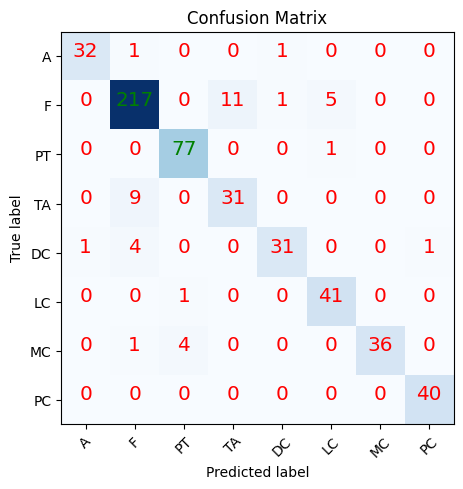

In [31]:
history = train_model(parallel_model,train_gen,val_gen,test_gen,mag,image_size,'maxvit',lr1,lr2,4,100)